In [1]:
import os, json, time
import numpy as np
import pandas as pd
import shap
import joblib
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import re

### Modelo MLP Base

In [ ]:
VERSION_TAG_MLP = "v1" 
BASE_MLP = "models"
SEED = 42
TOPK = 20

# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])

df_base =df_vcr_c.copy()
obj_cols = df_base.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols) + ["id", "latitud", "longitud"]
df_base = df_base.drop(columns=cols_to_drop)

In [3]:
# === Cargar artefactos ===
model = keras.models.load_model(os.path.join(BASE_MLP, f"best_model_mlp_{VERSION_TAG_MLP}.keras"))
scaler = joblib.load(os.path.join(BASE_MLP, f"scaler_mlp_{VERSION_TAG_MLP}.joblib"))
with open(os.path.join(BASE_MLP, f"feature_names_mlp_{VERSION_TAG_MLP}.json"), "r") as f:
    feature_names = json.load(f)

In [4]:
# === Datos ===
DF = df_base.copy()
X = DF[feature_names].values.astype(np.float32)
X_std = scaler.transform(X).astype(np.float32)

In [ ]:
# Parámetros 
TOPK = 20
BG_K = 128             # prototipos k-means para background
EX_N = 256           # filas a explicar
NSAMPLES = 256  # estabilidad numérica (evita matrices singulares)

# Background representativo (k-means sobre X_std)
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background_np = np.asarray(background, dtype=np.float32)

# Subconjunto a explicar
explain_X = X_std[:EX_N].astype(np.float32)

# Sanidad
assert background_np.ndim == 2 and explain_X.ndim == 2, "background/explain_X deben ser 2D"

# Explainer (modelo Keras)
t0 = time.perf_counter()
f_pred = lambda z: model.predict(z, verbose=0).ravel()
explainer = shap.KernelExplainer(f_pred, background_np, link="identity")
sv = explainer.shap_values(explain_X, nsamples=NSAMPLES)
shap_vals = sv[0] if isinstance(sv, list) else sv
shap_vals = np.asarray(shap_vals, dtype=np.float32)

# Normalizar forma a (n_samples, n_features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(-1, 1)
if shap_vals.shape[0] != explain_X.shape[0] and shap_vals.shape[1] == explain_X.shape[0]:
    shap_vals = shap_vals.T

print(
    f"[SHAP-MLP] backend=kernel | bg_n={background_np.shape[0]} | "
    f"ex_n={explain_X.shape[0]} | nsamples={NSAMPLES} | time={time.perf_counter()-t0:.2f}s"
)

# Importancias (valor absoluto) y signo (dirección promedio del efecto)
mean_shap = np.mean(shap_vals, axis=0)
imp = np.mean(np.abs(shap_vals), axis=0)
order = np.argsort(imp)[::-1]
sign_char = np.where(mean_shap >= 0, "+", "-")

# Top-K
TOPK = min(TOPK, len(feature_names))
shap_top_mlp = pd.DataFrame({
    "feature": np.array(feature_names)[order][:TOPK],
    "sign": sign_char[order][:TOPK],
    "mean_|shap|": imp[order][:TOPK],
    "mean_shap": mean_shap[order][:TOPK],  # magnitud firmada (opcional)
})

print("\n[MLP] Top-20 features por |SHAP| con signo:")
print(shap_top_mlp.to_string(index=False))

Using 128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/256 [00:00<?, ?it/s]

[SHAP-MLP] backend=kernel | bg_n=128 | ex_n=256 | nsamples=256 | time=739.30s

[MLP] Top-20 features por |SHAP| con signo:
             feature sign  mean_|shap|  mean_shap
        superficie_t    +     0.458255   0.372837
               banos    +     0.174470   0.142484
   flag_Departamento    +     0.165645   0.046700
     estacionamiento    +     0.088728   0.062277
       flag_Semipiso    -     0.071026  -0.033710
             terraza    +     0.045233   0.034411
         dormitorios    -     0.042294  -0.025211
             bodegas    +     0.038462   0.027488
     flag_Multinivel    +     0.029161   0.014582
        flag_Premium    +     0.022924   0.005773
          antiguedad    +     0.021525   0.012336
      banos_faltante    +     0.018817   0.014288
                Or_O    -     0.013296  -0.002020
                Or_E    +     0.011927   0.005743
   flag_Monoambiente    -     0.011320  -0.011069
         Or_Faltante    -     0.010551  -0.006772
                Or_S    -  

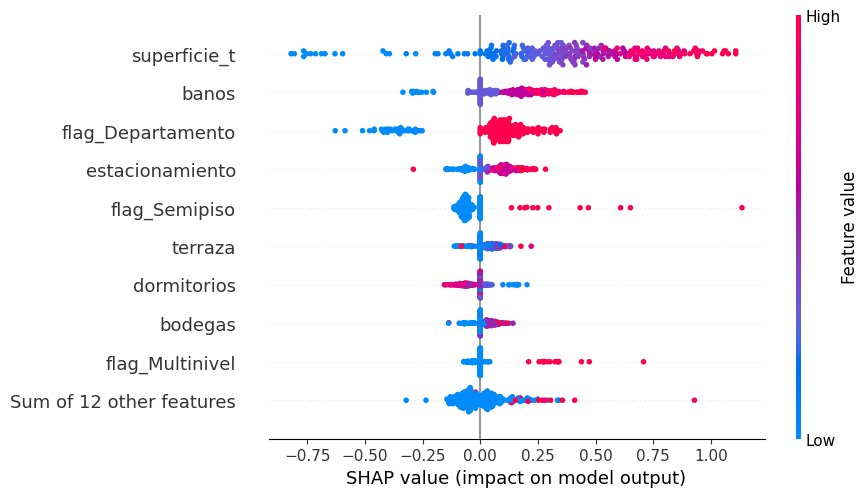

In [6]:
# Crea el objeto Explanation (opcional si explainer ya devuelve esto)
shap_values_mlp = shap.Explanation(
    values=sv,
    base_values=explainer.expected_value,
    data=explain_X,
    feature_names=feature_names
)

# Beeswarm plot
shap.plots.beeswarm(shap_values_mlp, show=True)

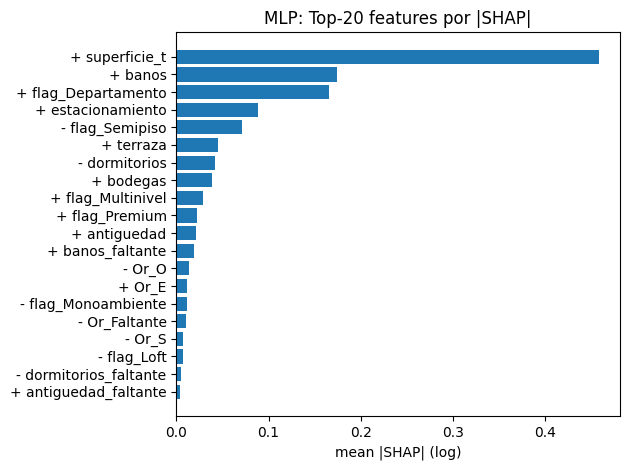

In [7]:
top = shap_top_mlp.copy()  # columnas: feature, sign, mean_|shap|, mean_shap
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("MLP: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()

### Modelo con coordenadas MLP

In [ ]:
VERSION_TAG_MLP = "v2" 
BASE_MLP = "models"
SEED = 42
TOPK = 20

# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])

#Configuración específica del modelo
df_coord =df_vcr_c.copy()
obj_cols = df_coord.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_coord = df_coord.drop(columns=cols_to_drop)

In [8]:
# === Cargar artefactos ===
model = keras.models.load_model(os.path.join(BASE_MLP, f"best_model_mlp_{VERSION_TAG_MLP}.keras"))
scaler = joblib.load(os.path.join(BASE_MLP, f"scaler_mlp_{VERSION_TAG_MLP}.joblib"))
with open(os.path.join(BASE_MLP, f"feature_names_mlp_{VERSION_TAG_MLP}.json"), "r") as f:
    feature_names = json.load(f)

In [9]:
# === Datos ===
DF = df_coord.copy()
X = DF[feature_names].values.astype(np.float32)
X_std = scaler.transform(X).astype(np.float32)

In [ ]:
# Parámetros (puedes ajustar)
TOPK = 20
BG_K = 128            # prototipos k-means para background
EX_N = 256             # filas a explicar
NSAMPLES = 256  # estabilidad numérica (evita matrices singulares)

# Background representativo (k-means sobre X_std)
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background_np = np.asarray(background, dtype=np.float32)

# Subconjunto a explicar
explain_X = X_std[:EX_N].astype(np.float32)

# Sanidad
assert background_np.ndim == 2 and explain_X.ndim == 2, "background/explain_X deben ser 2D"

# Explainer (modelo Keras)
t0 = time.perf_counter()
f_pred = lambda z: model.predict(z, verbose=0).ravel()
explainer = shap.KernelExplainer(f_pred, background_np, link="identity")
sv = explainer.shap_values(explain_X, nsamples=NSAMPLES)
shap_vals = sv[0] if isinstance(sv, list) else sv
shap_vals = np.asarray(shap_vals, dtype=np.float32)

# Normalizar forma a (n_samples, n_features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(-1, 1)
if shap_vals.shape[0] != explain_X.shape[0] and shap_vals.shape[1] == explain_X.shape[0]:
    shap_vals = shap_vals.T

print(
    f"[SHAP-MLP] backend=kernel | bg_n={background_np.shape[0]} | "
    f"ex_n={explain_X.shape[0]} | nsamples={NSAMPLES} | time={time.perf_counter()-t0:.2f}s"
)

# Importancias (valor absoluto) y signo (dirección promedio del efecto)
mean_shap = np.mean(shap_vals, axis=0)
imp = np.mean(np.abs(shap_vals), axis=0)
order = np.argsort(imp)[::-1]
sign_char = np.where(mean_shap >= 0, "+", "-")

# Top-K
TOPK = min(TOPK, len(feature_names))
shap_top_mlp = pd.DataFrame({
    "feature": np.array(feature_names)[order][:TOPK],
    "sign": sign_char[order][:TOPK],
    "mean_|shap|": imp[order][:TOPK],
    "mean_shap": mean_shap[order][:TOPK],  # magnitud firmada (opcional)
})

print("\n[MLP] Top-20 features por |SHAP| con signo:")
print(shap_top_mlp.to_string(index=False))

Using 128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/256 [00:00<?, ?it/s]

[SHAP-MLP] backend=kernel | bg_n=128 | ex_n=256 | nsamples=256 | time=739.01s

[MLP] Top-20 features por |SHAP| con signo:
             feature sign  mean_|shap|  mean_shap
        superficie_t    +     0.391319   0.328835
            longitud    +     0.233013   0.216377
             latitud    +     0.127573   0.123274
               banos    +     0.105328   0.092215
     estacionamiento    +     0.068368   0.056875
          antiguedad    +     0.031307   0.003222
   flag_Departamento    +     0.031054   0.011196
             terraza    +     0.027217   0.007593
             bodegas    +     0.013662   0.012021
        flag_Premium    +     0.010000   0.007620
         Or_Faltante    -     0.008372  -0.001824
       flag_Semipiso    +     0.008329   0.003404
         dormitorios    -     0.007796  -0.000890
      banos_faltante    +     0.006727   0.005706
     flag_Multinivel    +     0.006076   0.005009
                Or_O    +     0.005244   0.001548
                Or_S    +  

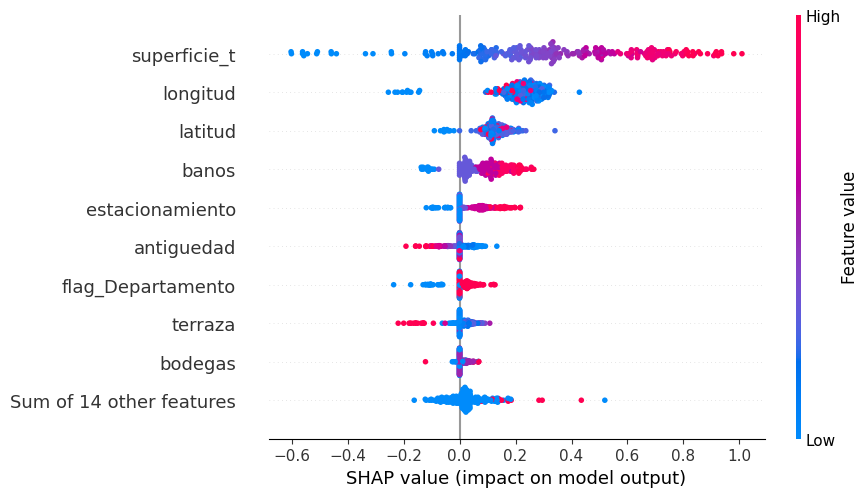

In [12]:
# Crea el objeto Explanation (opcional si explainer ya devuelve esto)
shap_values_mlp = shap.Explanation(
    values=sv,
    base_values=explainer.expected_value,
    data=explain_X,
    feature_names=feature_names
)

# Beeswarm plot
shap.plots.beeswarm(shap_values_mlp, show=True)

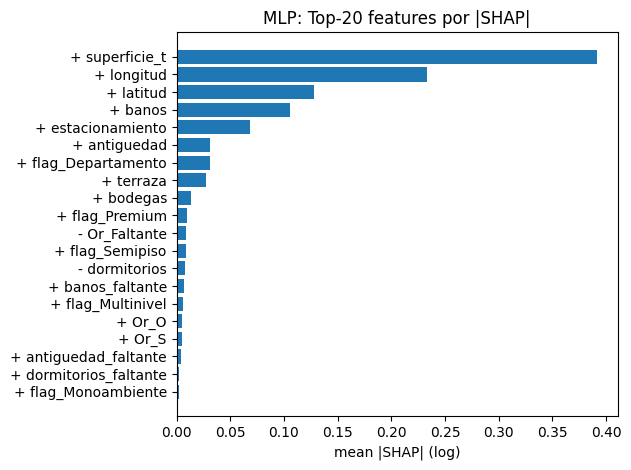

In [13]:
top = shap_top_mlp.copy()  # columnas: feature, sign, mean_|shap|, mean_shap
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("MLP: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()

### Modelo con VCR MLP

In [ ]:
VERSION_TAG_MLP = "v3" 
BASE_MLP = "models"
SEED = 42
TOPK = 20

df_vcr_e = pd.read_csv('dataset_vcr_expanded.csv')
df_vcr_e = df_vcr_e[df_vcr_e['monto'] < 56000].copy()
df_vcr_e['log_monto']=np.log(df_vcr_e['monto'])

df_vcr =df_vcr_e.copy()
obj_cols = df_vcr.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_vcr = df_vcr.drop(columns=cols_to_drop)

# Imputación datos faltantes en VCR
import re
from typing import Dict, Tuple, Optional

# Configuración (
# Dimensiones (1..12) 
DIMS_MAP = {
    1: "count_pois",
    2: "mean_distance",
    3: "min_distance",
    4: "max_distance",
    5: "median_distance",
    6: "std_distance",
    7: "mean_inverse_distance",
    8: "max_inverse_distance",
    9: "sum_inverse_distance",
    10: "ratio_within_near_radius",
    11: "ratio_within_mid_radius",
    12: "ratio_within_far_radius",
}

# Rol por dimensión (para decidir la imputación semántica)
DIM_ROLE = {
    1: "count",                # -> 0
    2: "distance",             # -> R3
    3: "distance",             # -> R3
    4: "distance",             # -> R3
    5: "distance",             # -> R3
    6: "std",                  # -> 0
    7: "inverse",              # -> 0
    8: "inverse",              # -> 0
    9: "inverse",              # -> 0
    10: "ratio",               # -> 0
    11: "ratio",               # -> 0
    12: "ratio",               # -> 0
}

# R3 por tipo de clase
R3_DEFAULT = 2400.0  # clases generales
R3_METRO = 1600.0
R3_BUS = 800.0

# Funciones
def _class_and_dim(col: str) -> Optional[Tuple[str, int]]:
    """Extrae (clase, índice de dimensión) de columnas tipo '<clase>_dimXX'."""
    m = re.match(r"^(?P<klass>.+)_dim(?P<idx>\d{1,2})$", col)
    if not m:
        return None
    return m.group("klass"), int(m.group("idx"))


def _r3_for_class(klass: str) -> float:
    k = klass.lower()
    if "metro" in k:
        return R3_METRO
    if "bus" in k:
        return R3_BUS
    return R3_DEFAULT


def impute_vcr_semantic(df: pd.DataFrame) -> pd.DataFrame:
    """Imputa VCR por semántica de ausencia: distancias=R3, inversas/ratios=0, count=0, std=0.
    Además agrega flags `has_<clase>` indicando presencia de POIs por clase.
    """
    out = df.copy()

    # Agrupar columnas por clase
    groups: Dict[str, Dict[int, str]] = {}
    vcr_cols = []
    for c in out.columns:
        parsed = _class_and_dim(c)
        if parsed is None:
            continue
        klass, idx = parsed
        groups.setdefault(klass, {})[idx] = c
        vcr_cols.append(c)

    if not groups:
        # Nada que imputar
        return out

    # Flags de presencia por clase (antes de imputar)
    for klass, dim_map in groups.items():
        cols = list(dim_map.values())
        has_series = out[cols].notna().any(axis=1).astype("int64")
        out[f"has_{klass}"] = has_series  # por qué: distingue ausencia real vs lejanía

    # Imputación por clase/dim
    n_total_nans = int(out[vcr_cols].isna().sum().sum())
    for klass, dim_map in groups.items():
        r3 = _r3_for_class(klass)
        for idx, col in dim_map.items():
            role = DIM_ROLE.get(idx)
            if role == "distance":
                fill_value = r3
            elif role in {"inverse", "ratio", "std", "count"}:
                fill_value = 0.0
            else:
                # Si hay una dimensión desconocida, ser conservador con 0.0
                fill_value = 0.0
            out[col] = out[col].fillna(fill_value)

    n_after_nans = int(out[vcr_cols].isna().sum().sum())
    print(f"Imputación VCR completada. NaNs antes: {n_total_nans:,d} -> después: {n_after_nans:,d}")

    return out



df_vcr_imp = impute_vcr_semantic(df_vcr)
df_vcr_imp.info()  


Imputación VCR completada. NaNs antes: 246,228 -> después: 0
<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Columns: 194 entries, monto to has_bus
dtypes: float64(161), int64(33)
memory usage: 37.5 MB


In [12]:
# === Cargar artefactos ===
model = keras.models.load_model(os.path.join(BASE_MLP, f"best_model_mlp_{VERSION_TAG_MLP}.keras"))
scaler = joblib.load(os.path.join(BASE_MLP, f"scaler_mlp_{VERSION_TAG_MLP}.joblib"))
with open(os.path.join(BASE_MLP, f"feature_names_mlp_{VERSION_TAG_MLP}.json"), "r") as f:
    feature_names = json.load(f)

In [13]:
# === Datos ===
DF = df_vcr_imp.copy()
X = DF[feature_names].values.astype(np.float32)
X_std = scaler.transform(X).astype(np.float32)

In [ ]:
# Parámetros (puedes ajustar)
TOPK = 20
BG_K = 128             # prototipos k-means para background
EX_N = 256           # filas a explicar
NSAMPLES = 256  # estabilidad numérica (evita matrices singulares)

# Background representativo (k-means sobre X_std)
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background_np = np.asarray(background, dtype=np.float32)

# Subconjunto a explicar
explain_X = X_std[:EX_N].astype(np.float32)

# Sanidad
assert background_np.ndim == 2 and explain_X.ndim == 2, "background/explain_X deben ser 2D"

# Explainer (modelo Keras)
t0 = time.perf_counter()
f_pred = lambda z: model.predict(z, verbose=0).ravel()
explainer = shap.KernelExplainer(f_pred, background_np, link="identity")
sv = explainer.shap_values(explain_X, nsamples=NSAMPLES)
shap_vals = sv[0] if isinstance(sv, list) else sv
shap_vals = np.asarray(shap_vals, dtype=np.float32)

# Normalizar forma a (n_samples, n_features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(-1, 1)
if shap_vals.shape[0] != explain_X.shape[0] and shap_vals.shape[1] == explain_X.shape[0]:
    shap_vals = shap_vals.T

print(
    f"[SHAP-MLP] backend=kernel | bg_n={background_np.shape[0]} | "
    f"ex_n={explain_X.shape[0]} | nsamples={NSAMPLES} | time={time.perf_counter()-t0:.2f}s"
)

# Importancias (valor absoluto) y signo (dirección promedio del efecto)
mean_shap = np.mean(shap_vals, axis=0)
imp = np.mean(np.abs(shap_vals), axis=0)
order = np.argsort(imp)[::-1]
sign_char = np.where(mean_shap >= 0, "+", "-")

# Top-K
TOPK = min(TOPK, len(feature_names))
shap_top_mlp = pd.DataFrame({
    "feature": np.array(feature_names)[order][:TOPK],
    "sign": sign_char[order][:TOPK],
    "mean_|shap|": imp[order][:TOPK],
    "mean_shap": mean_shap[order][:TOPK],  # magnitud firmada (opcional)
})

print("\n[MLP] Top-20 features por |SHAP| con signo:")
print(shap_top_mlp.to_string(index=False))

Using 128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/256 [00:00<?, ?it/s]

[SHAP-MLP] backend=kernel | bg_n=128 | ex_n=256 | nsamples=256 | time=831.02s

[MLP] Top-20 features por |SHAP| con signo:
                     feature sign  mean_|shap|  mean_shap
                superficie_t    +     0.316424   0.267332
                     latitud    +     0.095808   0.094641
                       banos    +     0.093560   0.083304
                    longitud    +     0.081412   0.076872
             estacionamiento    +     0.041615   0.038092
     sport_and_leisure_dim00    +     0.037268   0.037268
     sport_and_leisure_dim08    +     0.036021   0.036021
     sport_and_leisure_dim03    +     0.025680   0.025680
                  antiguedad    +     0.013213   0.012722
              banos_faltante    +     0.010408   0.010408
                 dormitorios    +     0.009850   0.004168
              security_dim02    +     0.007237   0.007237
              security_dim11    +     0.006123   0.005678
 food_and_drink_stores_dim00    +     0.005124   0.001654
       

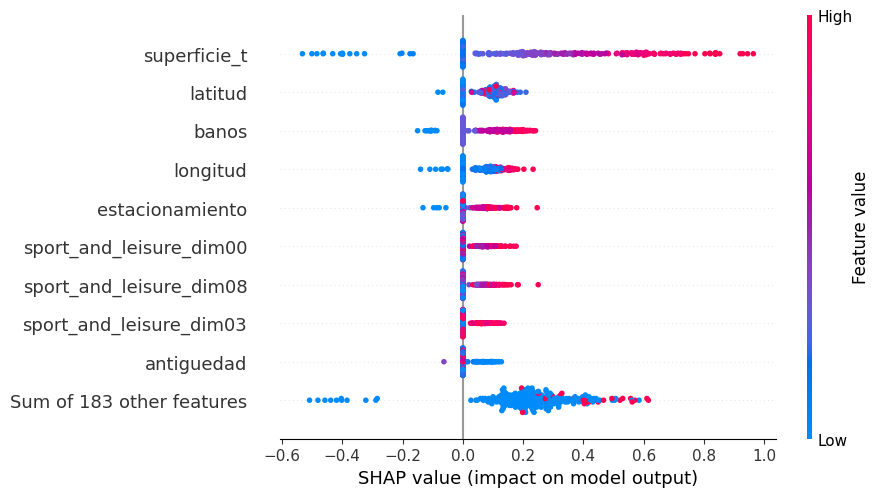

In [18]:
# Crea el objeto Explanation (opcional si explainer ya devuelve esto)
shap_values_mlp = shap.Explanation(
    values=sv,
    base_values=explainer.expected_value,
    data=explain_X,
    feature_names=feature_names
)

# Beeswarm plot
shap.plots.beeswarm(shap_values_mlp, show=True)

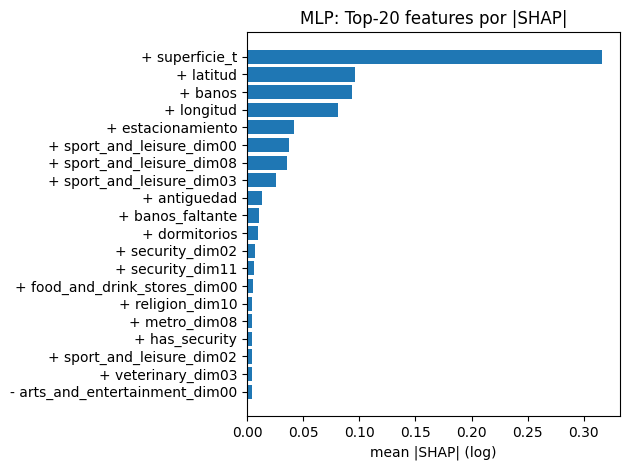

In [19]:
top = shap_top_mlp.copy()  # columnas: feature, sign, mean_|shap|, mean_shap
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("MLP: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()